# RNNS FOR SEQUENCE MODELING

#### Utils

In [ ]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional

In [2]:
# Function to plot MAE and Loss
def plot_mae(history, name):
    accuracy = history.history["mae"]
    val_accuracy = history.history["val_mae"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "b-o", label="Training MAE")
    plt.plot(epochs, val_accuracy, "r--o", label="Validation MAE")
    plt.title(f"Training and Validation MAE - {name}")
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, "b-o", label="Training Loss")
    plt.plot(epochs, val_loss, "r--o", label="Validation Loss")
    plt.title(f"Training and Validation Loss - {name}")
    plt.legend()

    plt.show()

In [3]:
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()

    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:]
    #print(header)
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]]

    return rawData

In [4]:
#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSaples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))

    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

In [5]:
def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

In [6]:
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, valPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)


    train_size = int(len(allTrain) * (1 - valPercent))
    val_size = len(allTrain) - train_size


    trainData, valData = allTrain[:train_size], allTrain[train_size:]


    print(f"Length of trainData: {len(trainData)}")
    print(f"Length of valData: {len(valData)}")

    for i in range(len(trainData)):
        tmp_train = generateTimeSeries(np.array(trainData[i]), np.array(trainData[i])[:, 0], seqLength, batchSize)


        if i < len(valData):
            tmp_val = generateTimeSeries(np.array(valData[i]), np.array(valData[i])[:, 0], seqLength, batchSize)
        else:
            tmp_val = None

        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:, 0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            val_dataset = tmp_val if tmp_val is not None else None
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            if tmp_val is not None:
                val_dataset = val_dataset.concatenate(tmp_val)
            test_dataset = test_dataset.concatenate(tmp_test)

    return train_dataset, val_dataset, test_dataset, stdSales, np.shape(allTrain)[2]



In [7]:
#generates a time series given the input and ouput data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):
    sampling_rate = 1 #keep all the data points
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks

    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)

    return dataset

### DATA PREPROCESSING AND EXPLORATION

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### We divide our data in test, validation and train datasets

In [20]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

testPercent = 0.2
valPercent=0.1
seqLength = 2
batchSize = 1
trainData, testData, valData, stdSales, nFeatures = generateTrainTestData("/content/drive/My Drive/Colab Notebooks/walmart-sales-dataset-of-45stores.csv",
    testPercent, valPercent, seqLength, batchSize)



Length of trainData: 40
Length of valData: 5


In [ ]:
# Show a batch for basic comprobations
for x, y in trainData.take(1):
    print("Example (X):", x.numpy().flatten())  # Entrada
    print("Example (Y):", y.numpy())  # Salida (ventas en t+3)


Example (X): [ 1.03935866 -0.29277002 -0.83009785 -1.54047353  1.0437828  -0.04137158
  1.03632736  3.41565026 -1.0321513  -1.59436757  1.04753093 -0.04137158]
Example (Y): [0.8839272]


In [ ]:
for x, y in trainData.take(1):
    print(f"Shape X: {x.shape}")
    print(f"Shape Y : {y.shape}")

Shape X: (1, 2, 6)
Shape Y : (1,)


##### As part of the exploration, we visualize the weekly sales distribution

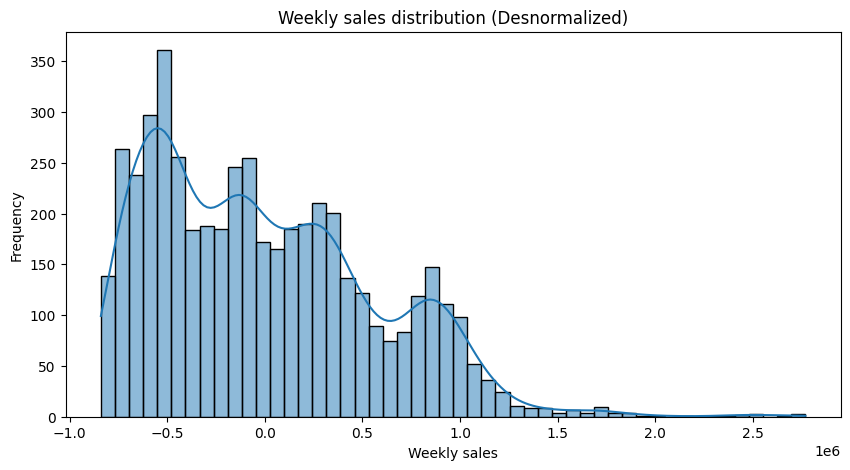

In [ ]:

train_sales = [y.numpy()[0] * stdSales for _, y in trainData]

plt.figure(figsize=(10, 5))
sns.histplot(train_sales, bins=50, kde=True)
plt.title('Weekly sales distribution (Desnormalized)')
plt.xlabel('Weekly sales')
plt.ylabel('Frequency')
plt.show()


### TRYING OUT SIMPLE RNNS AND LSTM ARQUITECTURES

##### We created a fuction to build diffrent configurations in a more efficient way. The first configurations we will try out are 2 layers models (Simple RNN and LSTM) considered as small models and 2 medium models of 4 layers each. We should take into account that we will be using one dense layer only and that all configurations will include a dropout layer as part of the regularization techniques

Training model: SimpleRNN_Small


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6924 - mae: 0.6188

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.6921 - mae: 0.6186 - val_loss: 0.1969 - val_mae: 0.3470 - learning_rate: 0.0010
Epoch 2/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.2119 - mae: 0.3237 - val_loss: 0.2544 - val_mae: 0.3946 - learning_rate: 0.0010
Epoch 3/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.1935 - mae: 0.3030 - val_loss: 0.2873 - val_mae: 0.4237 - learning_rate: 0.0010
Epoch 4/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1953 - mae: 0.3063 - val_loss: 0.2530 - val_mae: 0.3886 - learning_rate: 0.0010
Epoch 5/60
4347/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1968 - mae: 0.3068

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1967 - mae: 0.3067 - val_loss: 0.1023 - val_mae: 0.2466 - learning_rate: 5.0000e-04
Epoch 6/60
4340/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1876 - mae: 0.2948

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1875 - mae: 0.2948 - val_loss: 0.0869 - val_mae: 0.2252 - learning_rate: 5.0000e-04
Epoch 7/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.1862 - mae: 0.2959 - val_loss: 0.1069 - val_mae: 0.2486 - learning_rate: 5.0000e-04
Epoch 8/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1815 - mae: 0.2918 - val_loss: 0.1108 - val_mae: 0.2538 - learning_rate: 5.0000e-04
Epoch 9/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1750 - mae: 0.2870 - val_loss: 0.0920 - val_mae: 0.2303 - learning_rate: 5.0000e-04
Epoch 10/60
4344/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1761 - mae: 0.2879

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1760 - mae: 0.2879 - val_loss: 0.0558 - val_mae: 0.1791 - learning_rate: 2.5000e-04
Epoch 11/60
4347/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1796 - mae: 0.2927

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1796 - mae: 0.2927 - val_loss: 0.0537 - val_mae: 0.1765 - learning_rate: 2.5000e-04
Epoch 12/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1733 - mae: 0.2838 - val_loss: 0.0561 - val_mae: 0.1801 - learning_rate: 2.5000e-04
Epoch 13/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1803 - mae: 0.2917 - val_loss: 0.0557 - val_mae: 0.1801 - learning_rate: 2.5000e-04
Epoch 14/60
4350/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1652 - mae: 0.2834

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1651 - mae: 0.2834 - val_loss: 0.0533 - val_mae: 0.1771 - learning_rate: 2.5000e-04
Epoch 15/60
4347/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1867 - mae: 0.2925

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1866 - mae: 0.2924 - val_loss: 0.0381 - val_mae: 0.1492 - learning_rate: 1.2500e-04
Epoch 16/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1675 - mae: 0.2825

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1674 - mae: 0.2825 - val_loss: 0.0347 - val_mae: 0.1420 - learning_rate: 1.2500e-04
Epoch 17/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1716 - mae: 0.2882 - val_loss: 0.0353 - val_mae: 0.1432 - learning_rate: 1.2500e-04
Epoch 18/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1808 - mae: 0.2945 - val_loss: 0.0356 - val_mae: 0.1441 - learning_rate: 1.2500e-04
Epoch 19/60
4338/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1675 - mae: 0.2854

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.1675 - mae: 0.2853 - val_loss: 0.0335 - val_mae: 0.1402 - learning_rate: 1.2500e-04
Epoch 20/60
4352/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1674 - mae: 0.2806

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1673 - mae: 0.2806 - val_loss: 0.0335 - val_mae: 0.1395 - learning_rate: 1.2500e-04
Epoch 21/60
4348/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1765 - mae: 0.2910

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1765 - mae: 0.2909 - val_loss: 0.0330 - val_mae: 0.1378 - learning_rate: 1.2500e-04
Epoch 22/60
4353/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1707 - mae: 0.2898

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1707 - mae: 0.2897 - val_loss: 0.0325 - val_mae: 0.1359 - learning_rate: 1.2500e-04
Epoch 23/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1727 - mae: 0.2881 - val_loss: 0.0359 - val_mae: 0.1447 - learning_rate: 1.2500e-04
Epoch 24/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1694 - mae: 0.2795 - val_loss: 0.0336 - val_mae: 0.1388 - learning_rate: 1.2500e-04
Epoch 25/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1706 - mae: 0.2845 - val_loss: 0.0338 - val_mae: 0.1386 - learning_rate: 1.2500e-04
Epoch 26/60
4341/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1691 - mae: 0.2821

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1690 - mae: 0.2820 - val_loss: 0.0318 - val_mae: 0.1351 - learning_rate: 6.2500e-05
Epoch 27/60
4347/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1740 - mae: 0.2883

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1739 - mae: 0.2882 - val_loss: 0.0301 - val_mae: 0.1303 - learning_rate: 6.2500e-05
Epoch 28/60
4338/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1726 - mae: 0.2839

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1724 - mae: 0.2838 - val_loss: 0.0299 - val_mae: 0.1301 - learning_rate: 6.2500e-05
Epoch 29/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1640 - mae: 0.2796 - val_loss: 0.0299 - val_mae: 0.1299 - learning_rate: 6.2500e-05
Epoch 30/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.1698 - mae: 0.2799 - val_loss: 0.0306 - val_mae: 0.1326 - learning_rate: 6.2500e-05
Epoch 31/60
4350/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1636 - mae: 0.2768

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1636 - mae: 0.2768 - val_loss: 0.0296 - val_mae: 0.1293 - learning_rate: 6.2500e-05
Epoch 32/60
4339/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1638 - mae: 0.2803

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1637 - mae: 0.2802 - val_loss: 0.0293 - val_mae: 0.1289 - learning_rate: 6.2500e-05
Epoch 33/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1567 - mae: 0.2731 - val_loss: 0.0315 - val_mae: 0.1368 - learning_rate: 6.2500e-05
Epoch 34/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1724 - mae: 0.2852

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1724 - mae: 0.2852 - val_loss: 0.0285 - val_mae: 0.1261 - learning_rate: 6.2500e-05
Epoch 35/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.1623 - mae: 0.2792 - val_loss: 0.0299 - val_mae: 0.1294 - learning_rate: 6.2500e-05
Epoch 36/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.1612 - mae: 0.2764 - val_loss: 0.0301 - val_mae: 0.1312 - learning_rate: 6.2500e-05
Epoch 37/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1574 - mae: 0.2689 - val_loss: 0.0301 - val_mae: 0.1310 - learning_rate: 6.2500e-05
Epoch 38/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.1657 - mae: 0.2808 - val_loss: 0.0291 - val_mae: 0.1281 - learning_rate: 3.1250e-05
Epoch 39/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1648 - mae: 0.2810 - val_loss: 0.0286 - val_mae: 0.1261 - learning_rate: 3.1250e-05
Epoch 40/60
4341/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1615 - mae: 0.2794

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1614 - mae: 0.2793 - val_loss: 0.0278 - val_mae: 0.1241 - learning_rate: 3.1250e-05
Epoch 41/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1631 - mae: 0.2788 - val_loss: 0.0287 - val_mae: 0.1272 - learning_rate: 3.1250e-05
Epoch 42/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1667 - mae: 0.2820 - val_loss: 0.0291 - val_mae: 0.1286 - learning_rate: 3.1250e-05
Epoch 43/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1610 - mae: 0.2768

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1610 - mae: 0.2768 - val_loss: 0.0277 - val_mae: 0.1238 - learning_rate: 3.1250e-05
Epoch 44/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1604 - mae: 0.2725 - val_loss: 0.0283 - val_mae: 0.1258 - learning_rate: 3.1250e-05
Epoch 45/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1563 - mae: 0.2757 - val_loss: 0.0283 - val_mae: 0.1269 - learning_rate: 3.1250e-05
Epoch 46/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1648 - mae: 0.2789 - val_loss: 0.0295 - val_mae: 0.1306 - learning_rate: 3.1250e-05
Epoch 47/60
4345/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1654 - mae: 0.2797

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1653 - mae: 0.2796 - val_loss: 0.0275 - val_mae: 0.1230 - learning_rate: 1.5625e-05
Epoch 48/60
4338/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1639 - mae: 0.2809

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1638 - mae: 0.2808 - val_loss: 0.0275 - val_mae: 0.1225 - learning_rate: 1.5625e-05
Epoch 49/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.1611 - mae: 0.2789 - val_loss: 0.0282 - val_mae: 0.1249 - learning_rate: 1.5625e-05
Epoch 50/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1635 - mae: 0.2811 - val_loss: 0.0277 - val_mae: 0.1238 - learning_rate: 1.5625e-05
Epoch 51/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1592 - mae: 0.2785 - val_loss: 0.0285 - val_mae: 0.1265 - learning_rate: 1.5625e-05
Epoch 52/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1588 - mae: 0.2755 - val_loss: 0.0282 - val_mae: 0.1253 - learning_rate: 7.8125e-06
Epoch 53/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1586 - mae: 0.2782 - val_loss: 0.0279 - val_mae: 0.1235 - learning_rate: 7.8125e-06
Epoch 54/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1639 - mae: 0.2805 - val_loss: 0.0278 - val_ma

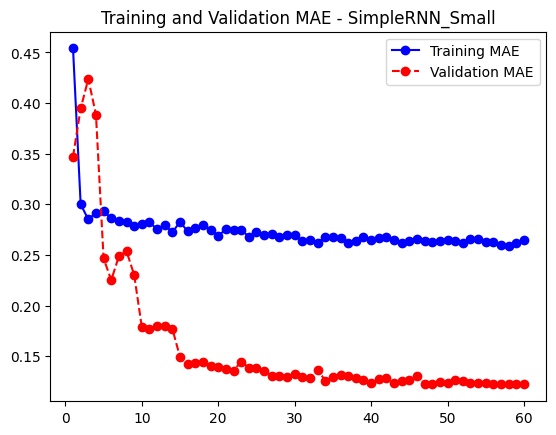

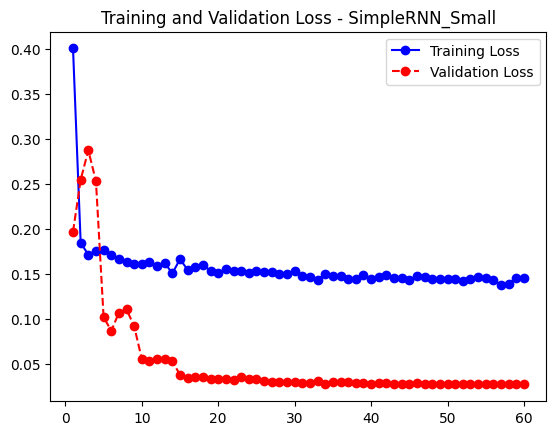

Training model: SimpleRNN_Medium


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9594 - mae: 0.7340

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.9593 - mae: 0.7340 - val_loss: 0.3860 - val_mae: 0.5037 - learning_rate: 0.0010
Epoch 2/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.2573 - mae: 0.3551 - val_loss: 0.4635 - val_mae: 0.5505 - learning_rate: 0.0010
Epoch 3/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.2184 - mae: 0.3244 - val_loss: 0.5046 - val_mae: 0.5863 - learning_rate: 0.0010
Epoch 4/60
4345/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2255 - mae: 0.3288

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2255 - mae: 0.3288 - val_loss: 0.3847 - val_mae: 0.4991 - learning_rate: 0.0010
Epoch 5/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.2148 - mae: 0.3187 - val_loss: 0.4272 - val_mae: 0.5309 - learning_rate: 0.0010
Epoch 6/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2078 - mae: 0.3140

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.2078 - mae: 0.3140 - val_loss: 0.3553 - val_mae: 0.4702 - learning_rate: 0.0010
Epoch 7/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.2161 - mae: 0.3184 - val_loss: 0.3740 - val_mae: 0.4935 - learning_rate: 0.0010
Epoch 8/60
4351/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2162 - mae: 0.3131

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.2161 - mae: 0.3131 - val_loss: 0.3209 - val_mae: 0.4515 - learning_rate: 0.0010
Epoch 9/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.1992 - mae: 0.3050 - val_loss: 0.3703 - val_mae: 0.4946 - learning_rate: 0.0010
Epoch 10/60
4348/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2084 - mae: 0.3145

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.2083 - mae: 0.3144 - val_loss: 0.2902 - val_mae: 0.4252 - learning_rate: 0.0010
Epoch 11/60
4343/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2011 - mae: 0.3077

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.2010 - mae: 0.3077 - val_loss: 0.2095 - val_mae: 0.3645 - learning_rate: 0.0010
Epoch 12/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.2025 - mae: 0.3056 - val_loss: 0.2941 - val_mae: 0.4331 - learning_rate: 0.0010
Epoch 13/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1983 - mae: 0.3044

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.1983 - mae: 0.3044 - val_loss: 0.2060 - val_mae: 0.3595 - learning_rate: 0.0010
Epoch 14/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.1997 - mae: 0.3103 - val_loss: 0.2130 - val_mae: 0.3649 - learning_rate: 0.0010
Epoch 15/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.1978 - mae: 0.3057 - val_loss: 0.2089 - val_mae: 0.3619 - learning_rate: 0.0010
Epoch 16/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.2015 - mae: 0.3112 - val_loss: 0.2095 - val_mae: 0.3663 - learning_rate: 0.0010
Epoch 17/60
4351/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2038 - mae: 0.3107

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.2038 - mae: 0.3107 - val_loss: 0.1397 - val_mae: 0.3005 - learning_rate: 5.0000e-04
Epoch 18/60
4349/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1993 - mae: 0.3059

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.1993 - mae: 0.3059 - val_loss: 0.1164 - val_mae: 0.2746 - learning_rate: 5.0000e-04
Epoch 19/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2082 - mae: 0.3161

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.2082 - mae: 0.3160 - val_loss: 0.1056 - val_mae: 0.2588 - learning_rate: 5.0000e-04
Epoch 20/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2050 - mae: 0.3131

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2049 - mae: 0.3131 - val_loss: 0.0989 - val_mae: 0.2493 - learning_rate: 5.0000e-04
Epoch 21/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2064 - mae: 0.3162 - val_loss: 0.1106 - val_mae: 0.2651 - learning_rate: 5.0000e-04
Epoch 22/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.2005 - mae: 0.3121 - val_loss: 0.1008 - val_mae: 0.2527 - learning_rate: 5.0000e-04
Epoch 23/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.1942 - mae: 0.3040 - val_loss: 0.1040 - val_mae: 0.2566 - learning_rate: 5.0000e-04
Epoch 24/60
4345/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2068 - mae: 0.3217

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2067 - mae: 0.3217 - val_loss: 0.0871 - val_mae: 0.2301 - learning_rate: 2.5000e-04
Epoch 25/60
4344/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2042 - mae: 0.3205

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2041 - mae: 0.3205 - val_loss: 0.0802 - val_mae: 0.2251 - learning_rate: 2.5000e-04
Epoch 26/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.2023 - mae: 0.3172 - val_loss: 0.0820 - val_mae: 0.2242 - learning_rate: 2.5000e-04
Epoch 27/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2043 - mae: 0.3158 - val_loss: 0.0834 - val_mae: 0.2272 - learning_rate: 2.5000e-04
Epoch 28/60
4347/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2074 - mae: 0.3212

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.2073 - mae: 0.3211 - val_loss: 0.0798 - val_mae: 0.2232 - learning_rate: 2.5000e-04
Epoch 29/60
4351/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2027 - mae: 0.3195

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.2027 - mae: 0.3194 - val_loss: 0.0738 - val_mae: 0.2183 - learning_rate: 2.5000e-04
Epoch 30/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.1980 - mae: 0.3162 - val_loss: 0.0788 - val_mae: 0.2218 - learning_rate: 2.5000e-04
Epoch 31/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2039 - mae: 0.3129

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.2039 - mae: 0.3129 - val_loss: 0.0695 - val_mae: 0.2126 - learning_rate: 2.5000e-04
Epoch 32/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.1984 - mae: 0.3105 - val_loss: 0.0730 - val_mae: 0.2147 - learning_rate: 2.5000e-04
Epoch 33/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2078 - mae: 0.3227

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.2078 - mae: 0.3227 - val_loss: 0.0691 - val_mae: 0.2114 - learning_rate: 2.5000e-04
Epoch 34/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.2015 - mae: 0.3164 - val_loss: 0.0704 - val_mae: 0.2117 - learning_rate: 2.5000e-04
Epoch 35/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.1995 - mae: 0.3110 - val_loss: 0.0766 - val_mae: 0.2188 - learning_rate: 2.5000e-04
Epoch 36/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1994 - mae: 0.3131 - val_loss: 0.0696 - val_mae: 0.2092 - learning_rate: 2.5000e-04
Epoch 37/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.2023 - mae: 0.3106 - val_loss: 0.0724 - val_mae: 0.2122 - learning_rate: 2.5000e-04
Epoch 38/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.2074 - mae: 0.3134 - val_loss: 0.0737 - val_mae: 0.2179 - learning_rate: 2.5000e-04
Epoch 39/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.1995 - mae: 0.3118 - val_loss: 0.0718 - val_ma

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2004 - mae: 0.3120 - val_loss: 0.0679 - val_mae: 0.2070 - learning_rate: 1.2500e-04
Epoch 41/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2035 - mae: 0.3164

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2035 - mae: 0.3164 - val_loss: 0.0636 - val_mae: 0.1997 - learning_rate: 1.2500e-04
Epoch 42/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2041 - mae: 0.3130 - val_loss: 0.0645 - val_mae: 0.2024 - learning_rate: 1.2500e-04
Epoch 43/60
4352/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1939 - mae: 0.3086

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.1939 - mae: 0.3086 - val_loss: 0.0611 - val_mae: 0.1963 - learning_rate: 1.2500e-04
Epoch 44/60
4351/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1993 - mae: 0.3162

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.1992 - mae: 0.3162 - val_loss: 0.0610 - val_mae: 0.1956 - learning_rate: 1.2500e-04
Epoch 45/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1996 - mae: 0.3158

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.1996 - mae: 0.3158 - val_loss: 0.0608 - val_mae: 0.1951 - learning_rate: 1.2500e-04
Epoch 46/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2015 - mae: 0.3110

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.2015 - mae: 0.3109 - val_loss: 0.0564 - val_mae: 0.1876 - learning_rate: 1.2500e-04
Epoch 47/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2043 - mae: 0.3158 - val_loss: 0.0580 - val_mae: 0.1914 - learning_rate: 1.2500e-04
Epoch 48/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.1992 - mae: 0.3119 - val_loss: 0.0608 - val_mae: 0.1942 - learning_rate: 1.2500e-04
Epoch 49/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2033 - mae: 0.3156 - val_loss: 0.0594 - val_mae: 0.1920 - learning_rate: 1.2500e-04
Epoch 50/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2034 - mae: 0.3184 - val_loss: 0.0571 - val_mae: 0.1887 - learning_rate: 6.2500e-05
Epoch 51/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.2019 - mae: 0.3207 - val_loss: 0.0574 - val_mae: 0.1890 - learning_rate: 6.2500e-05
Epoch 52/60
4347/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1986 - mae: 0.3129

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.1986 - mae: 0.3129 - val_loss: 0.0562 - val_mae: 0.1873 - learning_rate: 6.2500e-05
Epoch 53/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.2007 - mae: 0.3137 - val_loss: 0.0582 - val_mae: 0.1899 - learning_rate: 6.2500e-05
Epoch 54/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.2041 - mae: 0.3194 - val_loss: 0.0586 - val_mae: 0.1902 - learning_rate: 6.2500e-05
Epoch 55/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2041 - mae: 0.3186

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.2041 - mae: 0.3186 - val_loss: 0.0561 - val_mae: 0.1869 - learning_rate: 6.2500e-05
Epoch 56/60
4350/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2001 - mae: 0.3110

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.2001 - mae: 0.3110 - val_loss: 0.0555 - val_mae: 0.1872 - learning_rate: 6.2500e-05
Epoch 57/60
4345/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2024 - mae: 0.3155

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2024 - mae: 0.3155 - val_loss: 0.0554 - val_mae: 0.1875 - learning_rate: 6.2500e-05
Epoch 58/60
4352/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1989 - mae: 0.3108

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.1988 - mae: 0.3108 - val_loss: 0.0552 - val_mae: 0.1856 - learning_rate: 6.2500e-05
Epoch 59/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.2029 - mae: 0.3154 - val_loss: 0.0563 - val_mae: 0.1883 - learning_rate: 6.2500e-05
Epoch 60/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.2069 - mae: 0.3174 - val_loss: 0.0555 - val_mae: 0.1866 - learning_rate: 6.2500e-05
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1165 - mae: 0.2648


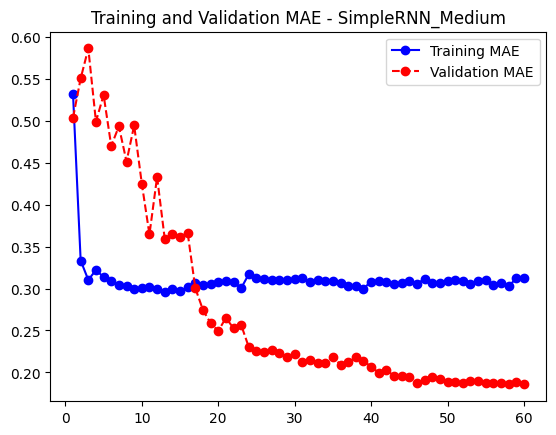

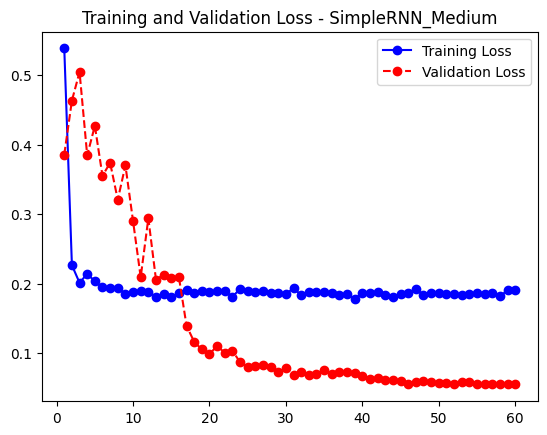

Training model: LSTM_Small


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3115 - mae: 0.3997

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.3114 - mae: 0.3996 - val_loss: 0.1403 - val_mae: 0.2815 - learning_rate: 0.0010
Epoch 2/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1875 - mae: 0.3010

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1875 - mae: 0.3010 - val_loss: 0.1237 - val_mae: 0.2517 - learning_rate: 0.0010
Epoch 3/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1724 - mae: 0.2896

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1724 - mae: 0.2896 - val_loss: 0.1061 - val_mae: 0.2314 - learning_rate: 0.0010
Epoch 4/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.1645 - mae: 0.2850 - val_loss: 0.1091 - val_mae: 0.2270 - learning_rate: 0.0010
Epoch 5/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1578 - mae: 0.2809

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1578 - mae: 0.2808 - val_loss: 0.0965 - val_mae: 0.2097 - learning_rate: 0.0010
Epoch 6/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1551 - mae: 0.2810

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1550 - mae: 0.2810 - val_loss: 0.0856 - val_mae: 0.2022 - learning_rate: 0.0010
Epoch 7/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1443 - mae: 0.2674 - val_loss: 0.1032 - val_mae: 0.2327 - learning_rate: 0.0010
Epoch 8/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1335 - mae: 0.2613 - val_loss: 0.0872 - val_mae: 0.2044 - learning_rate: 0.0010
Epoch 9/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.1324 - mae: 0.2606 - val_loss: 0.0996 - val_mae: 0.2162 - learning_rate: 0.0010
Epoch 10/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1412 - mae: 0.2675

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.1412 - mae: 0.2675 - val_loss: 0.0562 - val_mae: 0.1668 - learning_rate: 5.0000e-04
Epoch 11/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.1305 - mae: 0.2581 - val_loss: 0.0573 - val_mae: 0.1645 - learning_rate: 5.0000e-04
Epoch 12/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1283 - mae: 0.2561 - val_loss: 0.0594 - val_mae: 0.1662 - learning_rate: 5.0000e-04
Epoch 13/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1286 - mae: 0.2568

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.1285 - mae: 0.2568 - val_loss: 0.0546 - val_mae: 0.1646 - learning_rate: 5.0000e-04
Epoch 14/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1307 - mae: 0.2611

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.1307 - mae: 0.2611 - val_loss: 0.0535 - val_mae: 0.1609 - learning_rate: 5.0000e-04
Epoch 15/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.1237 - mae: 0.2534 - val_loss: 0.0591 - val_mae: 0.1686 - learning_rate: 5.0000e-04
Epoch 16/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1170 - mae: 0.2480 - val_loss: 0.0538 - val_mae: 0.1628 - learning_rate: 5.0000e-04
Epoch 17/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1207 - mae: 0.2526 - val_loss: 0.0583 - val_mae: 0.1657 - learning_rate: 5.0000e-04
Epoch 18/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1221 - mae: 0.2542

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.1221 - mae: 0.2542 - val_loss: 0.0476 - val_mae: 0.1526 - learning_rate: 2.5000e-04
Epoch 19/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1194 - mae: 0.2462

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1194 - mae: 0.2462 - val_loss: 0.0469 - val_mae: 0.1517 - learning_rate: 2.5000e-04
Epoch 20/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1268 - mae: 0.2579

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1268 - mae: 0.2578 - val_loss: 0.0410 - val_mae: 0.1502 - learning_rate: 2.5000e-04
Epoch 21/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.1185 - mae: 0.2480 - val_loss: 0.0423 - val_mae: 0.1471 - learning_rate: 2.5000e-04
Epoch 22/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1237 - mae: 0.2548 - val_loss: 0.0425 - val_mae: 0.1506 - learning_rate: 2.5000e-04
Epoch 23/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.1154 - mae: 0.2461 - val_loss: 0.0432 - val_mae: 0.1476 - learning_rate: 2.5000e-04
Epoch 24/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1239 - mae: 0.2505

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - loss: 0.1239 - mae: 0.2505 - val_loss: 0.0382 - val_mae: 0.1391 - learning_rate: 2.5000e-04
Epoch 25/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1195 - mae: 0.2486 - val_loss: 0.0402 - val_mae: 0.1432 - learning_rate: 2.5000e-04
Epoch 26/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - loss: 0.1268 - mae: 0.2547 - val_loss: 0.0433 - val_mae: 0.1518 - learning_rate: 2.5000e-04
Epoch 27/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1233 - mae: 0.2531

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1233 - mae: 0.2530 - val_loss: 0.0377 - val_mae: 0.1392 - learning_rate: 2.5000e-04
Epoch 28/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1246 - mae: 0.2540

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1246 - mae: 0.2540 - val_loss: 0.0319 - val_mae: 0.1312 - learning_rate: 1.2500e-04
Epoch 29/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1166 - mae: 0.2471 - val_loss: 0.0322 - val_mae: 0.1306 - learning_rate: 1.2500e-04
Epoch 30/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1184 - mae: 0.2477

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.1184 - mae: 0.2477 - val_loss: 0.0300 - val_mae: 0.1277 - learning_rate: 1.2500e-04
Epoch 31/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1170 - mae: 0.2493 - val_loss: 0.0307 - val_mae: 0.1266 - learning_rate: 1.2500e-04
Epoch 32/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1231 - mae: 0.2516 - val_loss: 0.0303 - val_mae: 0.1268 - learning_rate: 1.2500e-04
Epoch 33/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.1253 - mae: 0.2557 - val_loss: 0.0320 - val_mae: 0.1290 - learning_rate: 1.2500e-04
Epoch 34/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1131 - mae: 0.2444

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.1131 - mae: 0.2444 - val_loss: 0.0294 - val_mae: 0.1248 - learning_rate: 1.2500e-04
Epoch 35/60
4353/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1244 - mae: 0.2523

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - loss: 0.1244 - mae: 0.2522 - val_loss: 0.0283 - val_mae: 0.1246 - learning_rate: 1.2500e-04
Epoch 36/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1220 - mae: 0.2497 - val_loss: 0.0309 - val_mae: 0.1268 - learning_rate: 1.2500e-04
Epoch 37/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1182 - mae: 0.2449 - val_loss: 0.0341 - val_mae: 0.1305 - learning_rate: 1.2500e-04
Epoch 38/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1158 - mae: 0.2446 - val_loss: 0.0366 - val_mae: 0.1389 - learning_rate: 1.2500e-04
Epoch 39/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1272 - mae: 0.2544

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1272 - mae: 0.2544 - val_loss: 0.0269 - val_mae: 0.1174 - learning_rate: 6.2500e-05
Epoch 40/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1183 - mae: 0.2462

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1183 - mae: 0.2462 - val_loss: 0.0259 - val_mae: 0.1155 - learning_rate: 6.2500e-05
Epoch 41/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.1151 - mae: 0.2452 - val_loss: 0.0262 - val_mae: 0.1161 - learning_rate: 6.2500e-05
Epoch 42/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.1130 - mae: 0.2435 - val_loss: 0.0268 - val_mae: 0.1171 - learning_rate: 6.2500e-05
Epoch 43/60
4353/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1184 - mae: 0.2447

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - loss: 0.1184 - mae: 0.2447 - val_loss: 0.0252 - val_mae: 0.1133 - learning_rate: 6.2500e-05
Epoch 44/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1206 - mae: 0.2459 - val_loss: 0.0264 - val_mae: 0.1166 - learning_rate: 6.2500e-05
Epoch 45/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1229 - mae: 0.2503 - val_loss: 0.0270 - val_mae: 0.1181 - learning_rate: 6.2500e-05
Epoch 46/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.1189 - mae: 0.2465 - val_loss: 0.0262 - val_mae: 0.1156 - learning_rate: 6.2500e-05
Epoch 47/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1131 - mae: 0.2433

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1131 - mae: 0.2433 - val_loss: 0.0240 - val_mae: 0.1106 - learning_rate: 3.1250e-05
Epoch 48/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1175 - mae: 0.2460

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1175 - mae: 0.2459 - val_loss: 0.0239 - val_mae: 0.1109 - learning_rate: 3.1250e-05
Epoch 49/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1170 - mae: 0.2444 - val_loss: 0.0239 - val_mae: 0.1109 - learning_rate: 3.1250e-05
Epoch 50/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1184 - mae: 0.2505 - val_loss: 0.0243 - val_mae: 0.1130 - learning_rate: 3.1250e-05
Epoch 51/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1162 - mae: 0.2466

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1162 - mae: 0.2465 - val_loss: 0.0234 - val_mae: 0.1098 - learning_rate: 1.5625e-05
Epoch 52/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1175 - mae: 0.2471 - val_loss: 0.0237 - val_mae: 0.1101 - learning_rate: 1.5625e-05
Epoch 53/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.1156 - mae: 0.2445 - val_loss: 0.0236 - val_mae: 0.1102 - learning_rate: 1.5625e-05
Epoch 54/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1196 - mae: 0.2464

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.1196 - mae: 0.2464 - val_loss: 0.0234 - val_mae: 0.1094 - learning_rate: 1.5625e-05
Epoch 55/60
4352/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1193 - mae: 0.2475

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1193 - mae: 0.2475 - val_loss: 0.0233 - val_mae: 0.1090 - learning_rate: 1.5625e-05
Epoch 56/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.1158 - mae: 0.2438 - val_loss: 0.0234 - val_mae: 0.1092 - learning_rate: 1.5625e-05
Epoch 57/60
4353/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1165 - mae: 0.2468

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.1165 - mae: 0.2467 - val_loss: 0.0233 - val_mae: 0.1088 - learning_rate: 1.5625e-05
Epoch 58/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1225 - mae: 0.2511 - val_loss: 0.0234 - val_mae: 0.1092 - learning_rate: 1.5625e-05
Epoch 59/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.1192 - mae: 0.2460 - val_loss: 0.0236 - val_mae: 0.1099 - learning_rate: 1.5625e-05
Epoch 60/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1125 - mae: 0.2421 - val_loss: 0.0234 - val_mae: 0.1098 - learning_rate: 1.5625e-05
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0439 - mae: 0.1310


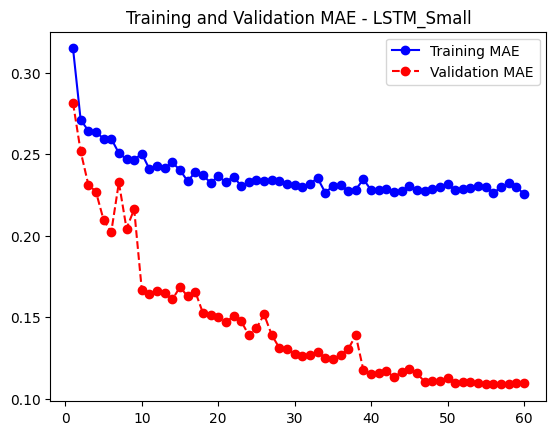

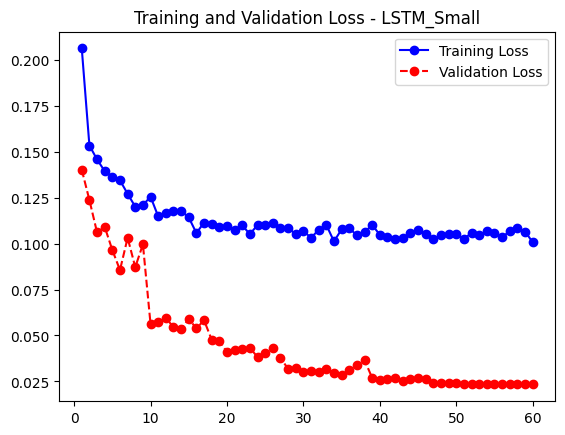

Training model: LSTM_Medium


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4183 - mae: 0.4576

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 52s 11ms/step - loss: 0.4182 - mae: 0.4575 - val_loss: 0.2276 - val_mae: 0.3458 - learning_rate: 0.0010
Epoch 2/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2126 - mae: 0.3189

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 0.2126 - mae: 0.3189 - val_loss: 0.1730 - val_mae: 0.2928 - learning_rate: 0.0010
Epoch 3/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1911 - mae: 0.3030

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 0.1911 - mae: 0.3030 - val_loss: 0.1461 - val_mae: 0.2694 - learning_rate: 0.0010
Epoch 4/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1794 - mae: 0.2941

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1794 - mae: 0.2941 - val_loss: 0.1016 - val_mae: 0.2326 - learning_rate: 0.0010
Epoch 5/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.1777 - mae: 0.2880 - val_loss: 0.1612 - val_mae: 0.2791 - learning_rate: 0.0010
Epoch 6/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 0.1752 - mae: 0.2910 - val_loss: 0.1772 - val_mae: 0.3009 - learning_rate: 0.0010
Epoch 7/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - loss: 0.1686 - mae: 0.2925 - val_loss: 0.1390 - val_mae: 0.2727 - learning_rate: 0.0010
Epoch 8/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1715 - mae: 0.2978 - val_loss: 0.1165 - val_mae: 0.2594 - learning_rate: 5.0000e-04
Epoch 9/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1492 - mae: 0.2786 - val_loss: 0.1087 - val_mae: 0.2481 - learning_rate: 5.0000e-04
Epoch 10/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1495 - mae: 0.2794

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1495 - mae: 0.2794 - val_loss: 0.0860 - val_mae: 0.2227 - learning_rate: 5.0000e-04
Epoch 11/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1512 - mae: 0.2821 - val_loss: 0.1073 - val_mae: 0.2456 - learning_rate: 5.0000e-04
Epoch 12/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - loss: 0.1472 - mae: 0.2773 - val_loss: 0.0950 - val_mae: 0.2259 - learning_rate: 5.0000e-04
Epoch 13/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1420 - mae: 0.2734 - val_loss: 0.0909 - val_mae: 0.2247 - learning_rate: 5.0000e-04
Epoch 14/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1529 - mae: 0.2798

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1529 - mae: 0.2798 - val_loss: 0.0494 - val_mae: 0.1697 - learning_rate: 2.5000e-04
Epoch 15/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1399 - mae: 0.2697 - val_loss: 0.0542 - val_mae: 0.1754 - learning_rate: 2.5000e-04
Epoch 16/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1474 - mae: 0.2736

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 0.1474 - mae: 0.2736 - val_loss: 0.0441 - val_mae: 0.1580 - learning_rate: 2.5000e-04
Epoch 17/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1484 - mae: 0.2766 - val_loss: 0.0477 - val_mae: 0.1631 - learning_rate: 2.5000e-04
Epoch 18/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1311 - mae: 0.2673 - val_loss: 0.0504 - val_mae: 0.1705 - learning_rate: 2.5000e-04
Epoch 19/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - loss: 0.1403 - mae: 0.2700 - val_loss: 0.0465 - val_mae: 0.1620 - learning_rate: 2.5000e-04
Epoch 20/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1396 - mae: 0.2706

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1396 - mae: 0.2706 - val_loss: 0.0375 - val_mae: 0.1466 - learning_rate: 1.2500e-04
Epoch 21/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1407 - mae: 0.2738

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1407 - mae: 0.2738 - val_loss: 0.0353 - val_mae: 0.1416 - learning_rate: 1.2500e-04
Epoch 22/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 0.1379 - mae: 0.2642 - val_loss: 0.0368 - val_mae: 0.1445 - learning_rate: 1.2500e-04
Epoch 23/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1371 - mae: 0.2689

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.1371 - mae: 0.2689 - val_loss: 0.0315 - val_mae: 0.1349 - learning_rate: 1.2500e-04
Epoch 24/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1423 - mae: 0.2703 - val_loss: 0.0341 - val_mae: 0.1366 - learning_rate: 1.2500e-04
Epoch 25/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1488 - mae: 0.2726 - val_loss: 0.0333 - val_mae: 0.1356 - learning_rate: 1.2500e-04
Epoch 26/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 0.1405 - mae: 0.2743 - val_loss: 0.0321 - val_mae: 0.1333 - learning_rate: 1.2500e-04
Epoch 27/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.1371 - mae: 0.2697 - val_loss: 0.0353 - val_mae: 0.1391 - learning_rate: 1.2500e-04
Epoch 28/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1345 - mae: 0.2637

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1344 - mae: 0.2637 - val_loss: 0.0306 - val_mae: 0.1304 - learning_rate: 1.2500e-04
Epoch 29/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1355 - mae: 0.2700 - val_loss: 0.0330 - val_mae: 0.1340 - learning_rate: 1.2500e-04
Epoch 30/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1270 - mae: 0.2589

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1270 - mae: 0.2589 - val_loss: 0.0305 - val_mae: 0.1299 - learning_rate: 1.2500e-04
Epoch 31/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1317 - mae: 0.2630

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1317 - mae: 0.2630 - val_loss: 0.0304 - val_mae: 0.1319 - learning_rate: 1.2500e-04
Epoch 32/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1323 - mae: 0.2662

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 0.1323 - mae: 0.2662 - val_loss: 0.0294 - val_mae: 0.1282 - learning_rate: 1.2500e-04
Epoch 33/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 53s 12ms/step - loss: 0.1328 - mae: 0.2645 - val_loss: 0.0301 - val_mae: 0.1292 - learning_rate: 1.2500e-04
Epoch 34/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 76s 11ms/step - loss: 0.1383 - mae: 0.2687 - val_loss: 0.0305 - val_mae: 0.1296 - learning_rate: 1.2500e-04
Epoch 35/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1385 - mae: 0.2666 - val_loss: 0.0327 - val_mae: 0.1351 - learning_rate: 1.2500e-04
Epoch 36/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1355 - mae: 0.2687

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1355 - mae: 0.2687 - val_loss: 0.0276 - val_mae: 0.1236 - learning_rate: 6.2500e-05
Epoch 37/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 0.1349 - mae: 0.2619 - val_loss: 0.0278 - val_mae: 0.1242 - learning_rate: 6.2500e-05
Epoch 38/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.1362 - mae: 0.2669 - val_loss: 0.0296 - val_mae: 0.1277 - learning_rate: 6.2500e-05
Epoch 39/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1380 - mae: 0.2711 - val_loss: 0.0302 - val_mae: 0.1286 - learning_rate: 6.2500e-05
Epoch 40/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1359 - mae: 0.2687

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1359 - mae: 0.2687 - val_loss: 0.0260 - val_mae: 0.1201 - learning_rate: 3.1250e-05
Epoch 41/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1319 - mae: 0.2640

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 0.1319 - mae: 0.2640 - val_loss: 0.0257 - val_mae: 0.1198 - learning_rate: 3.1250e-05
Epoch 42/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 0.1316 - mae: 0.2673 - val_loss: 0.0259 - val_mae: 0.1200 - learning_rate: 3.1250e-05
Epoch 43/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1350 - mae: 0.2668 - val_loss: 0.0264 - val_mae: 0.1217 - learning_rate: 3.1250e-05
Epoch 44/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1367 - mae: 0.2648 - val_loss: 0.0264 - val_mae: 0.1215 - learning_rate: 3.1250e-05
Epoch 45/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1401 - mae: 0.2682

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 0.1400 - mae: 0.2682 - val_loss: 0.0253 - val_mae: 0.1188 - learning_rate: 1.5625e-05
Epoch 46/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1316 - mae: 0.2633 - val_loss: 0.0254 - val_mae: 0.1188 - learning_rate: 1.5625e-05
Epoch 47/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1344 - mae: 0.2649

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.1344 - mae: 0.2649 - val_loss: 0.0252 - val_mae: 0.1183 - learning_rate: 1.5625e-05
Epoch 48/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 0.1336 - mae: 0.2674 - val_loss: 0.0253 - val_mae: 0.1187 - learning_rate: 1.5625e-05
Epoch 49/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1337 - mae: 0.2657 - val_loss: 0.0255 - val_mae: 0.1190 - learning_rate: 1.5625e-05
Epoch 50/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1376 - mae: 0.2685 - val_loss: 0.0255 - val_mae: 0.1197 - learning_rate: 1.5625e-05
Epoch 51/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1332 - mae: 0.2657 - val_loss: 0.0253 - val_mae: 0.1188 - learning_rate: 7.8125e-06
Epoch 52/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1376 - mae: 0.2668

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1376 - mae: 0.2667 - val_loss: 0.0251 - val_mae: 0.1183 - learning_rate: 7.8125e-06
Epoch 53/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1318 - mae: 0.2613

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1318 - mae: 0.2613 - val_loss: 0.0251 - val_mae: 0.1180 - learning_rate: 7.8125e-06
Epoch 54/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.1292 - mae: 0.2578 - val_loss: 0.0251 - val_mae: 0.1180 - learning_rate: 7.8125e-06
Epoch 55/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.1291 - mae: 0.2593 - val_loss: 0.0251 - val_mae: 0.1180 - learning_rate: 7.8125e-06
Epoch 56/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 0.1279 - mae: 0.2625 - val_loss: 0.0251 - val_mae: 0.1180 - learning_rate: 7.8125e-06
Epoch 57/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1278 - mae: 0.2623

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1278 - mae: 0.2623 - val_loss: 0.0250 - val_mae: 0.1178 - learning_rate: 3.9063e-06
Epoch 58/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1294 - mae: 0.2621

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1294 - mae: 0.2620 - val_loss: 0.0250 - val_mae: 0.1177 - learning_rate: 3.9063e-06
Epoch 59/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1369 - mae: 0.2652

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 0.1369 - mae: 0.2652 - val_loss: 0.0250 - val_mae: 0.1176 - learning_rate: 3.9063e-06
Epoch 60/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1264 - mae: 0.2605

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 0.1264 - mae: 0.2605 - val_loss: 0.0249 - val_mae: 0.1176 - learning_rate: 3.9063e-06
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0542 - mae: 0.1626


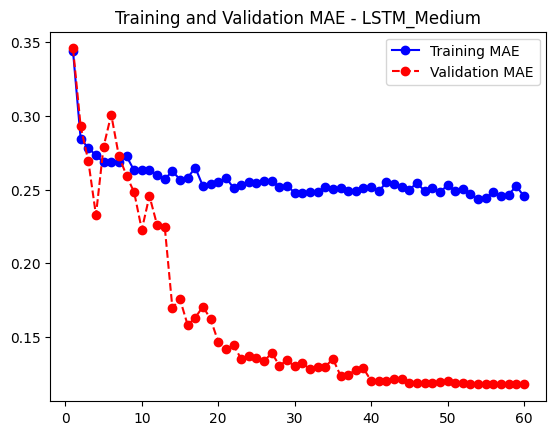

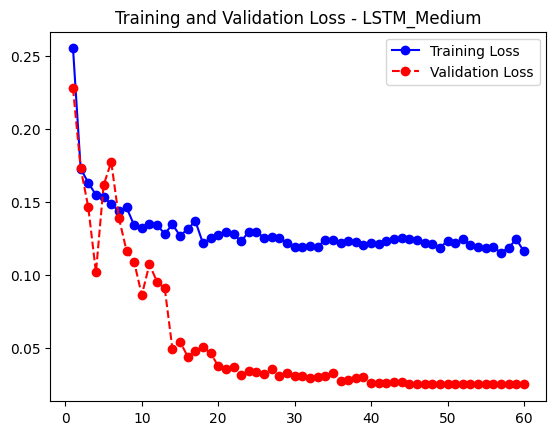

SimpleRNN_Small: Loss (MSE) = 0.041416559368371964, MAE = 0.13295993208885193, MAE denormalized =76033.77272114986
SimpleRNN_Medium: Loss (MSE) = 0.13552139699459076, MAE = 0.30165621638298035, MAE denormalized =172503.54927271063
LSTM_Small: Loss (MSE) = 0.03102814592421055, MAE = 0.11392704397439957, MAE denormalized =65149.724674597936
LSTM_Medium: Loss (MSE) = 0.04223356023430824, MAE = 0.15116776525974274, MAE denormalized =86446.00915441592


In [ ]:
# Define model configurations
def get_configurations():
    return {
        "SimpleRNN_Small": {"Type": SimpleRNN, "Depth": 2, "Units": 32, "DenseLayers": 1},
        "SimpleRNN_Medium": {"Type": SimpleRNN, "Depth": 4, "Units": 32, "DenseLayers": 1},

        "LSTM_Small": {"Type": LSTM, "Depth": 2, "Units": 32, "DenseLayers": 1},
        "LSTM_Medium": {"Type": LSTM, "Depth": 4, "Units": 32, "DenseLayers": 1},


    }

# Function to build RNN models based on configuration
def build_rnn(config):
    model = Sequential()
    for i in range(config["Depth"]):
        return_sequences = i < config["Depth"] - 1
        model.add(config["Type"](config["Units"], return_sequences=return_sequences))
        model.add(Dropout(0.5))

   
    for _ in range(config["DenseLayers"] - 1):
        model.add(Dense(64, activation='relu'))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Train models with different configurations
configs = get_configurations()
results = {}

for name, config in configs.items():
    print(f"Training model: {name}")
    model = build_rnn(config)
    model.summary()

    # Define callbacks
    checkpoint = ModelCheckpoint(f"{name}.h5", save_best_only=True, monitor='val_loss', mode='min')
    lr_scheduler = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3, mode='min', min_lr=1e-07)

    history = model.fit(trainData, epochs=60, batch_size = 128, validation_data=valData,
                        callbacks=[checkpoint, lr_scheduler])
    results[name] = model.evaluate(testData)
    plot_mae(history, name)



# Display results
for name, result in results.items():
    print(f"{name}: Loss (MSE) = {result[0]}, MAE = {result[1]}, MAE denormalized ={result[1]* stdSales}")



### **Overfitting Analysis and Model Comparison**  

In this section, we analyze the behavior of different models in terms of **MAE (Mean Absolute Error)** and **overfitting**.  

- For **SimpleRNN**, we observe clear overfitting in the small configuration, which is mitigated in the medium-sized approach.  
- In the **LSTM** models, no overfitting is detected in any of the configurations.  

Regarding the **denormalized MAE**, we can see that **SimpleRNN performs the worst**, while LSTM architectures show more stable performance with lower error values.




*   SimpleRNN_Small: Loss (MSE) = 0.041416559368371964, MAE = 0.13295993208885193, MAE denormalized =76033.77272114986
*   SimpleRNN_Medium: Loss (MSE) = 0.13552139699459076, MAE = 0.30165621638298035, MAE denormalized =172503.54927271063


*   LSTM_Small: Loss (MSE) = 0.03102814592421055, MAE = 0.11392704397439957, MAE denormalized =65149.724674597936
*   LSTM_Medium: Loss (MSE) = 0.04223356023430824, MAE = 0.15116776525974274, MAE denormalized =86446.00915441592













### TRYING OUT GRU ARQUITECTURES

Training model: GRU_Small


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2951 - mae: 0.3870

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.2950 - mae: 0.3869 - val_loss: 0.1151 - val_mae: 0.2745 - learning_rate: 0.0010
Epoch 2/60
4352/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1923 - mae: 0.3071

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.1922 - mae: 0.3071 - val_loss: 0.0956 - val_mae: 0.2222 - learning_rate: 0.0010
Epoch 3/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1821 - mae: 0.2965

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1820 - mae: 0.2964 - val_loss: 0.0919 - val_mae: 0.2234 - learning_rate: 0.0010
Epoch 4/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.1680 - mae: 0.2844 - val_loss: 0.0997 - val_mae: 0.2227 - learning_rate: 0.0010
Epoch 5/60
4353/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1640 - mae: 0.2842

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1639 - mae: 0.2841 - val_loss: 0.0884 - val_mae: 0.2136 - learning_rate: 0.0010
Epoch 6/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1707 - mae: 0.2885 - val_loss: 0.0929 - val_mae: 0.2130 - learning_rate: 0.0010
Epoch 7/60
4348/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1457 - mae: 0.2694

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.1457 - mae: 0.2694 - val_loss: 0.0836 - val_mae: 0.2055 - learning_rate: 0.0010
Epoch 8/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.1580 - mae: 0.2839 - val_loss: 0.1191 - val_mae: 0.2519 - learning_rate: 0.0010
Epoch 9/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.1543 - mae: 0.2742 - val_loss: 0.0896 - val_mae: 0.2039 - learning_rate: 0.0010
Epoch 10/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.1455 - mae: 0.2709 - val_loss: 0.0981 - val_mae: 0.2158 - learning_rate: 0.0010
Epoch 11/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1498 - mae: 0.2723

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.1498 - mae: 0.2723 - val_loss: 0.0662 - val_mae: 0.1797 - learning_rate: 0.0010
Epoch 12/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1406 - mae: 0.2698 - val_loss: 0.0833 - val_mae: 0.1974 - learning_rate: 0.0010
Epoch 13/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.1360 - mae: 0.2691 - val_loss: 0.0874 - val_mae: 0.2010 - learning_rate: 0.0010
Epoch 14/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1308 - mae: 0.2602 - val_loss: 0.0693 - val_mae: 0.1853 - learning_rate: 0.0010
Epoch 15/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1464 - mae: 0.2702

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1463 - mae: 0.2702 - val_loss: 0.0462 - val_mae: 0.1544 - learning_rate: 5.0000e-04
Epoch 16/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.1248 - mae: 0.2541 - val_loss: 0.0576 - val_mae: 0.1688 - learning_rate: 5.0000e-04
Epoch 17/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 0.1262 - mae: 0.2567 - val_loss: 0.0509 - val_mae: 0.1609 - learning_rate: 5.0000e-04
Epoch 18/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1265 - mae: 0.2574 - val_loss: 0.0740 - val_mae: 0.1903 - learning_rate: 5.0000e-04
Epoch 19/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1300 - mae: 0.2602 - val_loss: 0.0499 - val_mae: 0.1616 - learning_rate: 2.5000e-04
Epoch 20/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.1294 - mae: 0.2569 - val_loss: 0.0559 - val_mae: 0.1695 - learning_rate: 2.5000e-04
Epoch 21/60
4353/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1293 - mae: 0.2626

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 0.1292 - mae: 0.2626 - val_loss: 0.0315 - val_mae: 0.1316 - learning_rate: 2.5000e-04
Epoch 22/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.1252 - mae: 0.2530 - val_loss: 0.0541 - val_mae: 0.1669 - learning_rate: 2.5000e-04
Epoch 23/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.1121 - mae: 0.2435 - val_loss: 0.0412 - val_mae: 0.1530 - learning_rate: 2.5000e-04
Epoch 24/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.1261 - mae: 0.2548 - val_loss: 0.0365 - val_mae: 0.1404 - learning_rate: 2.5000e-04
Epoch 25/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1262 - mae: 0.2561

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1262 - mae: 0.2561 - val_loss: 0.0290 - val_mae: 0.1243 - learning_rate: 1.2500e-04
Epoch 26/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.1253 - mae: 0.2548 - val_loss: 0.0309 - val_mae: 0.1310 - learning_rate: 1.2500e-04
Epoch 27/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1236 - mae: 0.2522 - val_loss: 0.0342 - val_mae: 0.1374 - learning_rate: 1.2500e-04
Epoch 28/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.1243 - mae: 0.2527 - val_loss: 0.0343 - val_mae: 0.1347 - learning_rate: 1.2500e-04
Epoch 29/60
4352/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1217 - mae: 0.2498

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.1216 - mae: 0.2498 - val_loss: 0.0283 - val_mae: 0.1236 - learning_rate: 6.2500e-05
Epoch 30/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1207 - mae: 0.2513

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.1207 - mae: 0.2513 - val_loss: 0.0260 - val_mae: 0.1183 - learning_rate: 6.2500e-05
Epoch 31/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1260 - mae: 0.2579

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.1259 - mae: 0.2579 - val_loss: 0.0252 - val_mae: 0.1160 - learning_rate: 6.2500e-05
Epoch 32/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.1200 - mae: 0.2536 - val_loss: 0.0260 - val_mae: 0.1166 - learning_rate: 6.2500e-05
Epoch 33/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.1246 - mae: 0.2563 - val_loss: 0.0263 - val_mae: 0.1189 - learning_rate: 6.2500e-05
Epoch 34/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.1288 - mae: 0.2553 - val_loss: 0.0259 - val_mae: 0.1188 - learning_rate: 6.2500e-05
Epoch 35/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1218 - mae: 0.2527

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.1218 - mae: 0.2527 - val_loss: 0.0237 - val_mae: 0.1124 - learning_rate: 3.1250e-05
Epoch 36/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.1288 - mae: 0.2567 - val_loss: 0.0245 - val_mae: 0.1142 - learning_rate: 3.1250e-05
Epoch 37/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - loss: 0.1278 - mae: 0.2553 - val_loss: 0.0240 - val_mae: 0.1123 - learning_rate: 3.1250e-05
Epoch 38/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.1184 - mae: 0.2463 - val_loss: 0.0242 - val_mae: 0.1125 - learning_rate: 3.1250e-05
Epoch 39/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.1211 - mae: 0.2514 - val_loss: 0.0238 - val_mae: 0.1122 - learning_rate: 3.1250e-05
Epoch 40/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.1244 - mae: 0.2528 - val_loss: 0.0246 - val_mae: 0.1138 - learning_rate: 3.1250e-05
Epoch 41/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1195 - mae: 0.2470

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.1195 - mae: 0.2470 - val_loss: 0.0235 - val_mae: 0.1118 - learning_rate: 1.5625e-05
Epoch 42/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1184 - mae: 0.2492

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.1183 - mae: 0.2492 - val_loss: 0.0232 - val_mae: 0.1107 - learning_rate: 1.5625e-05
Epoch 43/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.1253 - mae: 0.2543 - val_loss: 0.0235 - val_mae: 0.1116 - learning_rate: 1.5625e-05
Epoch 44/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - loss: 0.1220 - mae: 0.2574 - val_loss: 0.0233 - val_mae: 0.1107 - learning_rate: 1.5625e-05
Epoch 45/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1226 - mae: 0.2539

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.1225 - mae: 0.2539 - val_loss: 0.0231 - val_mae: 0.1098 - learning_rate: 1.5625e-05
Epoch 46/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.1185 - mae: 0.2493 - val_loss: 0.0233 - val_mae: 0.1105 - learning_rate: 1.5625e-05
Epoch 47/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.1230 - mae: 0.2536 - val_loss: 0.0232 - val_mae: 0.1109 - learning_rate: 1.5625e-05
Epoch 48/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1226 - mae: 0.2506

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1226 - mae: 0.2505 - val_loss: 0.0230 - val_mae: 0.1098 - learning_rate: 1.5625e-05
Epoch 49/60
4351/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1186 - mae: 0.2488

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1186 - mae: 0.2488 - val_loss: 0.0229 - val_mae: 0.1097 - learning_rate: 7.8125e-06
Epoch 50/60
4351/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1209 - mae: 0.2520

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.1209 - mae: 0.2519 - val_loss: 0.0228 - val_mae: 0.1092 - learning_rate: 7.8125e-06
Epoch 51/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.1217 - mae: 0.2499 - val_loss: 0.0228 - val_mae: 0.1095 - learning_rate: 7.8125e-06
Epoch 52/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1216 - mae: 0.2507

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.1216 - mae: 0.2506 - val_loss: 0.0227 - val_mae: 0.1090 - learning_rate: 7.8125e-06
Epoch 53/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1143 - mae: 0.2474

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - loss: 0.1143 - mae: 0.2473 - val_loss: 0.0227 - val_mae: 0.1090 - learning_rate: 7.8125e-06
Epoch 54/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1222 - mae: 0.2518 - val_loss: 0.0228 - val_mae: 0.1094 - learning_rate: 7.8125e-06
Epoch 55/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1271 - mae: 0.2548

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.1270 - mae: 0.2548 - val_loss: 0.0227 - val_mae: 0.1088 - learning_rate: 7.8125e-06
Epoch 56/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.1262 - mae: 0.2554 - val_loss: 0.0229 - val_mae: 0.1095 - learning_rate: 7.8125e-06
Epoch 57/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.1235 - mae: 0.2528 - val_loss: 0.0229 - val_mae: 0.1100 - learning_rate: 7.8125e-06
Epoch 58/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - loss: 0.1207 - mae: 0.2505 - val_loss: 0.0228 - val_mae: 0.1091 - learning_rate: 7.8125e-06
Epoch 59/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.1304 - mae: 0.2541 - val_loss: 0.0228 - val_mae: 0.1093 - learning_rate: 3.9063e-06
Epoch 60/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.1210 - mae: 0.2512 - val_loss: 0.0228 - val_mae: 0.1095 - learning_rate: 3.9063e-06
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0503 - mae: 0.1428


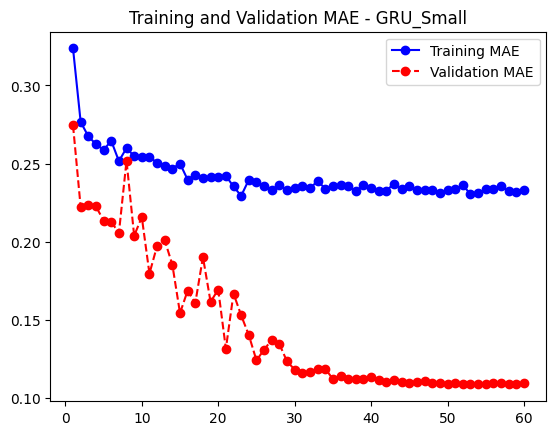

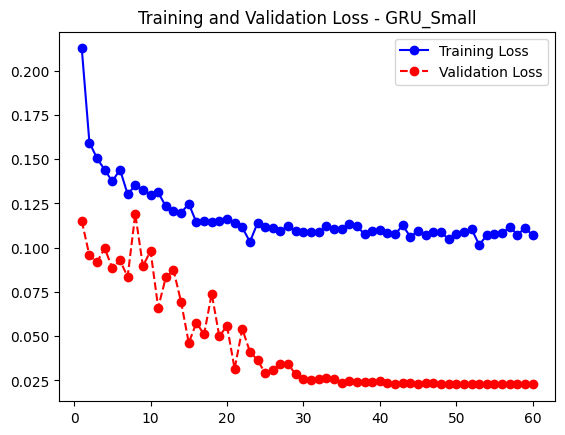

Training model: GRU_Medium


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3799 - mae: 0.4375

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 0.3798 - mae: 0.4375 - val_loss: 0.2409 - val_mae: 0.3865 - learning_rate: 0.0010
Epoch 2/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2197 - mae: 0.3212

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - loss: 0.2196 - mae: 0.3212 - val_loss: 0.1981 - val_mae: 0.3335 - learning_rate: 0.0010
Epoch 3/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1946 - mae: 0.3018 - val_loss: 0.2467 - val_mae: 0.3582 - learning_rate: 0.0010
Epoch 4/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1976 - mae: 0.3030

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - loss: 0.1976 - mae: 0.3030 - val_loss: 0.1790 - val_mae: 0.2904 - learning_rate: 0.0010
Epoch 5/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1897 - mae: 0.2952

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 85s 13ms/step - loss: 0.1896 - mae: 0.2952 - val_loss: 0.1561 - val_mae: 0.2985 - learning_rate: 0.0010
Epoch 6/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1903 - mae: 0.2979

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 0.1903 - mae: 0.2979 - val_loss: 0.1366 - val_mae: 0.2556 - learning_rate: 0.0010
Epoch 7/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1839 - mae: 0.2950

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - loss: 0.1839 - mae: 0.2950 - val_loss: 0.1312 - val_mae: 0.2604 - learning_rate: 0.0010
Epoch 8/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - loss: 0.1807 - mae: 0.2940 - val_loss: 0.1438 - val_mae: 0.2711 - learning_rate: 0.0010
Epoch 9/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 0.1666 - mae: 0.2840 - val_loss: 0.1504 - val_mae: 0.2803 - learning_rate: 0.0010
Epoch 10/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1732 - mae: 0.2905

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 0.1731 - mae: 0.2905 - val_loss: 0.1000 - val_mae: 0.2397 - learning_rate: 5.0000e-04
Epoch 11/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1630 - mae: 0.2831

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - loss: 0.1629 - mae: 0.2831 - val_loss: 0.0829 - val_mae: 0.2187 - learning_rate: 5.0000e-04
Epoch 12/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - loss: 0.1538 - mae: 0.2773 - val_loss: 0.0886 - val_mae: 0.2257 - learning_rate: 5.0000e-04
Epoch 13/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1483 - mae: 0.2758

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 53s 12ms/step - loss: 0.1482 - mae: 0.2758 - val_loss: 0.0749 - val_mae: 0.2105 - learning_rate: 5.0000e-04
Epoch 14/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 0.1682 - mae: 0.2901 - val_loss: 0.0996 - val_mae: 0.2414 - learning_rate: 5.0000e-04
Epoch 15/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 0.1556 - mae: 0.2763 - val_loss: 0.1031 - val_mae: 0.2466 - learning_rate: 5.0000e-04
Epoch 16/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 88s 14ms/step - loss: 0.1443 - mae: 0.2696 - val_loss: 0.0859 - val_mae: 0.2237 - learning_rate: 5.0000e-04
Epoch 17/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1497 - mae: 0.2760

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 53s 12ms/step - loss: 0.1497 - mae: 0.2760 - val_loss: 0.0657 - val_mae: 0.2002 - learning_rate: 2.5000e-04
Epoch 18/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1500 - mae: 0.2729

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 0.1500 - mae: 0.2729 - val_loss: 0.0605 - val_mae: 0.1861 - learning_rate: 2.5000e-04
Epoch 19/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1425 - mae: 0.2663

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - loss: 0.1424 - mae: 0.2663 - val_loss: 0.0556 - val_mae: 0.1816 - learning_rate: 2.5000e-04
Epoch 20/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 0.1548 - mae: 0.2800 - val_loss: 0.0571 - val_mae: 0.1839 - learning_rate: 2.5000e-04
Epoch 21/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1453 - mae: 0.2725 - val_loss: 0.0558 - val_mae: 0.1805 - learning_rate: 2.5000e-04
Epoch 22/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1534 - mae: 0.2795 - val_loss: 0.0602 - val_mae: 0.1938 - learning_rate: 2.5000e-04
Epoch 23/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1451 - mae: 0.2730 - val_loss: 0.0602 - val_mae: 0.1914 - learning_rate: 2.5000e-04
Epoch 24/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1375 - mae: 0.2688 - val_loss: 0.0699 - val_mae: 0.2008 - learning_rate: 2.5000e-04
Epoch 25/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1490 - mae: 0.2768

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 0.1489 - mae: 0.2768 - val_loss: 0.0397 - val_mae: 0.1509 - learning_rate: 1.2500e-04
Epoch 26/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1432 - mae: 0.2718

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 61s 14ms/step - loss: 0.1431 - mae: 0.2718 - val_loss: 0.0371 - val_mae: 0.1476 - learning_rate: 1.2500e-04
Epoch 27/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - loss: 0.1454 - mae: 0.2725 - val_loss: 0.0402 - val_mae: 0.1528 - learning_rate: 1.2500e-04
Epoch 28/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - loss: 0.1406 - mae: 0.2692 - val_loss: 0.0426 - val_mae: 0.1592 - learning_rate: 1.2500e-04
Epoch 29/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 0.1398 - mae: 0.2719 - val_loss: 0.0411 - val_mae: 0.1539 - learning_rate: 1.2500e-04
Epoch 30/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1465 - mae: 0.2774

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - loss: 0.1465 - mae: 0.2774 - val_loss: 0.0341 - val_mae: 0.1413 - learning_rate: 6.2500e-05
Epoch 31/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1515 - mae: 0.2747

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - loss: 0.1515 - mae: 0.2747 - val_loss: 0.0328 - val_mae: 0.1363 - learning_rate: 6.2500e-05
Epoch 32/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1359 - mae: 0.2659

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - loss: 0.1359 - mae: 0.2659 - val_loss: 0.0319 - val_mae: 0.1353 - learning_rate: 6.2500e-05
Epoch 33/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1365 - mae: 0.2670

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - loss: 0.1365 - mae: 0.2670 - val_loss: 0.0306 - val_mae: 0.1345 - learning_rate: 6.2500e-05
Epoch 34/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1415 - mae: 0.2695

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 0.1415 - mae: 0.2695 - val_loss: 0.0296 - val_mae: 0.1302 - learning_rate: 6.2500e-05
Epoch 35/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 87s 14ms/step - loss: 0.1536 - mae: 0.2782 - val_loss: 0.0306 - val_mae: 0.1322 - learning_rate: 6.2500e-05
Epoch 36/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 0.1400 - mae: 0.2709 - val_loss: 0.0309 - val_mae: 0.1320 - learning_rate: 6.2500e-05
Epoch 37/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1348 - mae: 0.2700

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 77s 11ms/step - loss: 0.1348 - mae: 0.2700 - val_loss: 0.0291 - val_mae: 0.1305 - learning_rate: 6.2500e-05
Epoch 38/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1434 - mae: 0.2750

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - loss: 0.1434 - mae: 0.2750 - val_loss: 0.0280 - val_mae: 0.1280 - learning_rate: 3.1250e-05
Epoch 39/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - loss: 0.1355 - mae: 0.2654 - val_loss: 0.0287 - val_mae: 0.1295 - learning_rate: 3.1250e-05
Epoch 40/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 87s 14ms/step - loss: 0.1398 - mae: 0.2681 - val_loss: 0.0280 - val_mae: 0.1263 - learning_rate: 3.1250e-05
Epoch 41/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1477 - mae: 0.2779

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - loss: 0.1477 - mae: 0.2779 - val_loss: 0.0272 - val_mae: 0.1247 - learning_rate: 3.1250e-05
Epoch 42/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1412 - mae: 0.2667

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1412 - mae: 0.2667 - val_loss: 0.0271 - val_mae: 0.1241 - learning_rate: 3.1250e-05
Epoch 43/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1417 - mae: 0.2697

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1417 - mae: 0.2697 - val_loss: 0.0271 - val_mae: 0.1248 - learning_rate: 3.1250e-05
Epoch 44/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1401 - mae: 0.2697 - val_loss: 0.0271 - val_mae: 0.1252 - learning_rate: 3.1250e-05
Epoch 45/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 84s 13ms/step - loss: 0.1436 - mae: 0.2691 - val_loss: 0.0271 - val_mae: 0.1258 - learning_rate: 3.1250e-05
Epoch 46/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1375 - mae: 0.2667

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - loss: 0.1375 - mae: 0.2667 - val_loss: 0.0267 - val_mae: 0.1246 - learning_rate: 1.5625e-05
Epoch 47/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1526 - mae: 0.2816

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 0.1526 - mae: 0.2816 - val_loss: 0.0265 - val_mae: 0.1238 - learning_rate: 1.5625e-05
Epoch 48/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 0.1440 - mae: 0.2710 - val_loss: 0.0265 - val_mae: 0.1243 - learning_rate: 1.5625e-05
Epoch 49/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 0.1423 - mae: 0.2708 - val_loss: 0.0265 - val_mae: 0.1240 - learning_rate: 1.5625e-05
Epoch 50/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.1526 - mae: 0.2819 - val_loss: 0.0265 - val_mae: 0.1238 - learning_rate: 1.5625e-05
Epoch 51/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1360 - mae: 0.2670

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 0.1360 - mae: 0.2670 - val_loss: 0.0263 - val_mae: 0.1231 - learning_rate: 7.8125e-06
Epoch 52/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1445 - mae: 0.2760

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 0.1444 - mae: 0.2759 - val_loss: 0.0262 - val_mae: 0.1233 - learning_rate: 7.8125e-06
Epoch 53/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1396 - mae: 0.2687

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1396 - mae: 0.2687 - val_loss: 0.0261 - val_mae: 0.1232 - learning_rate: 7.8125e-06
Epoch 54/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1411 - mae: 0.2716

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 0.1411 - mae: 0.2716 - val_loss: 0.0261 - val_mae: 0.1225 - learning_rate: 7.8125e-06
Epoch 55/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 0.1431 - mae: 0.2731 - val_loss: 0.0263 - val_mae: 0.1232 - learning_rate: 7.8125e-06
Epoch 56/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - loss: 0.1408 - mae: 0.2670 - val_loss: 0.0264 - val_mae: 0.1230 - learning_rate: 7.8125e-06
Epoch 57/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 55s 12ms/step - loss: 0.1401 - mae: 0.2680 - val_loss: 0.0266 - val_mae: 0.1233 - learning_rate: 7.8125e-06
Epoch 58/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1402 - mae: 0.2690 - val_loss: 0.0264 - val_mae: 0.1234 - learning_rate: 3.9063e-06
Epoch 59/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 0.1383 - mae: 0.2697 - val_loss: 0.0263 - val_mae: 0.1233 - learning_rate: 3.9063e-06
Epoch 60/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - loss: 0.1436 - mae: 0.2702 - val_loss: 0.0263 -

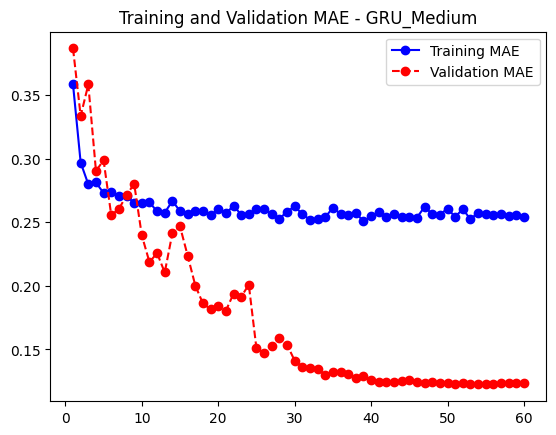

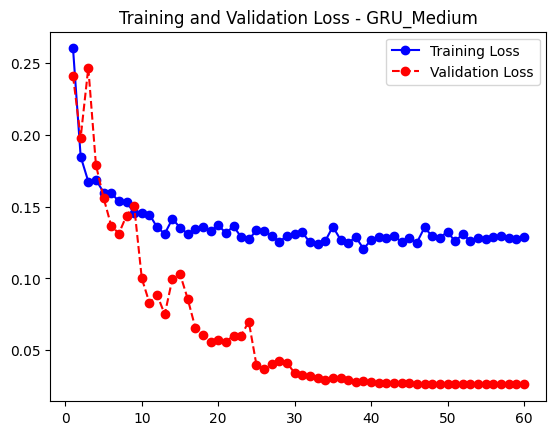

GRU_Small: Loss (MSE) = 0.03550444170832634, MAE = 0.1268918812274933, MAE denormalized =72563.728830449
GRU_Medium: Loss (MSE) = 0.045377857983112335, MAE = 0.1604275405406952, MAE denormalized =91741.2559110882


In [ ]:


# Define model configurations
def get_configurations():
    return {
        "GRU_Small": {"Type": GRU, "Depth": 2, "Units": 32, "DenseLayers": 1},
        "GRU_Medium": {"Type": GRU, "Depth": 4, "Units": 32, "DenseLayers": 1},


    }

# Function to build RNN models based on configuration
def build_rnn(config):
    model = Sequential()
    for i in range(config["Depth"]):
        return_sequences = i < config["Depth"] - 1
        model.add(config["Type"](config["Units"], return_sequences=return_sequences))
        model.add(Dropout(0.5))


    for _ in range(config["DenseLayers"] - 1):
        model.add(Dense(64, activation='relu'))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Train models with different configurations
configs = get_configurations()
results = {}

for name, config in configs.items():
    print(f"Training model: {name}")
    model = build_rnn(config)
    model.summary()

    # Define callbacks
    checkpoint = ModelCheckpoint(f"{name}.h5", save_best_only=True, monitor='val_loss', mode='min')
    lr_scheduler = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3, mode='min', min_lr=1e-07)

    history = model.fit(trainData, epochs=60, batch_size = 128, validation_data=valData,
                        callbacks=[checkpoint, lr_scheduler])
    results[name] = model.evaluate(testData)
    plot_mae(history, name)



# Display results
for name, result in results.items():
    print(f"{name}: Loss (MSE) = {result[0]}, MAE = {result[1]}, MAE denormalized ={result[1]* stdSales}")

### **Model Performance Comparison**  


Both **GRU** architectures show stable performance, achieving similar error levels. The  MAE indicates that both models are effective in minimizing prediction errors.  

#### **Results Comparison**

* GRU_Small: Loss (MSE) = 0.03550444170832634, MAE = 0.1268918812274933, MAE denormalized =72563.728830449
* GRU_Medium: Loss (MSE) = 0.045377857983112335, MAE = 0.1604275405406952, MAE denormalized =91741.2559110882

### TRYING OUT BIDIRECTIONAL APPROACH WITH BEST CONFIGURATION (LSTM SMALL)

#### In this case we wil try out bidirectional layers with the LSTM SMALL arquitecture to try to get a better result

Training model: LSTM_Small


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2385 - mae: 0.3414

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.2384 - mae: 0.3414 - val_loss: 0.1082 - val_mae: 0.2548 - learning_rate: 0.0010
Epoch 2/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1670 - mae: 0.2800

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.1670 - mae: 0.2800 - val_loss: 0.0860 - val_mae: 0.2186 - learning_rate: 0.0010
Epoch 3/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1495 - mae: 0.2638 - val_loss: 0.1289 - val_mae: 0.2480 - learning_rate: 0.0010
Epoch 4/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1316 - mae: 0.2561 - val_loss: 0.1006 - val_mae: 0.2236 - learning_rate: 0.0010
Epoch 5/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1248 - mae: 0.2485 - val_loss: 0.0866 - val_mae: 0.1966 - learning_rate: 0.0010
Epoch 6/60
4356/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1205 - mae: 0.2464

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.1205 - mae: 0.2464 - val_loss: 0.0799 - val_mae: 0.1933 - learning_rate: 0.0010
Epoch 7/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1139 - mae: 0.2414 - val_loss: 0.0900 - val_mae: 0.2021 - learning_rate: 0.0010
Epoch 8/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1107 - mae: 0.2370 - val_loss: 0.0869 - val_mae: 0.2062 - learning_rate: 0.0010
Epoch 9/60
4352/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1114 - mae: 0.2362

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1114 - mae: 0.2362 - val_loss: 0.0653 - val_mae: 0.1788 - learning_rate: 0.0010
Epoch 10/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.1045 - mae: 0.2278 - val_loss: 0.0736 - val_mae: 0.1894 - learning_rate: 0.0010
Epoch 11/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1045 - mae: 0.2302 - val_loss: 0.0971 - val_mae: 0.2112 - learning_rate: 0.0010
Epoch 12/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1061 - mae: 0.2284 - val_loss: 0.0956 - val_mae: 0.2061 - learning_rate: 0.0010
Epoch 13/60
4352/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1020 - mae: 0.2278

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1020 - mae: 0.2278 - val_loss: 0.0618 - val_mae: 0.1735 - learning_rate: 5.0000e-04
Epoch 14/60
4357/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0960 - mae: 0.2198

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0960 - mae: 0.2198 - val_loss: 0.0558 - val_mae: 0.1678 - learning_rate: 5.0000e-04
Epoch 15/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0942 - mae: 0.2199

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.0942 - mae: 0.2199 - val_loss: 0.0458 - val_mae: 0.1535 - learning_rate: 5.0000e-04
Epoch 16/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.0950 - mae: 0.2207 - val_loss: 0.0597 - val_mae: 0.1711 - learning_rate: 5.0000e-04
Epoch 17/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0993 - mae: 0.2234 - val_loss: 0.0535 - val_mae: 0.1682 - learning_rate: 5.0000e-04
Epoch 18/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.0917 - mae: 0.2175 - val_loss: 0.0578 - val_mae: 0.1694 - learning_rate: 5.0000e-04
Epoch 19/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.0967 - mae: 0.2228 - val_loss: 0.0487 - val_mae: 0.1592 - learning_rate: 2.5000e-04
Epoch 20/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0918 - mae: 0.2200

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.0918 - mae: 0.2200 - val_loss: 0.0384 - val_mae: 0.1444 - learning_rate: 2.5000e-04
Epoch 21/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0937 - mae: 0.2158 - val_loss: 0.0504 - val_mae: 0.1643 - learning_rate: 2.5000e-04
Epoch 22/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0885 - mae: 0.2118 - val_loss: 0.0392 - val_mae: 0.1456 - learning_rate: 2.5000e-04
Epoch 23/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.0906 - mae: 0.2144 - val_loss: 0.0438 - val_mae: 0.1521 - learning_rate: 2.5000e-04
Epoch 24/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0917 - mae: 0.2177

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.0917 - mae: 0.2177 - val_loss: 0.0315 - val_mae: 0.1308 - learning_rate: 1.2500e-04
Epoch 25/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0955 - mae: 0.2206 - val_loss: 0.0350 - val_mae: 0.1378 - learning_rate: 1.2500e-04
Epoch 26/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.0897 - mae: 0.2161 - val_loss: 0.0326 - val_mae: 0.1345 - learning_rate: 1.2500e-04
Epoch 27/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0933 - mae: 0.2215

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.0933 - mae: 0.2215 - val_loss: 0.0301 - val_mae: 0.1277 - learning_rate: 1.2500e-04
Epoch 28/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0902 - mae: 0.2141 - val_loss: 0.0315 - val_mae: 0.1313 - learning_rate: 1.2500e-04
Epoch 29/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0904 - mae: 0.2178 - val_loss: 0.0317 - val_mae: 0.1336 - learning_rate: 1.2500e-04
Epoch 30/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0907 - mae: 0.2146 - val_loss: 0.0321 - val_mae: 0.1302 - learning_rate: 1.2500e-04
Epoch 31/60
4351/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0930 - mae: 0.2160

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.0930 - mae: 0.2159 - val_loss: 0.0264 - val_mae: 0.1180 - learning_rate: 6.2500e-05
Epoch 32/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.0869 - mae: 0.2136 - val_loss: 0.0272 - val_mae: 0.1203 - learning_rate: 6.2500e-05
Epoch 33/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0913 - mae: 0.2185

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0913 - mae: 0.2185 - val_loss: 0.0256 - val_mae: 0.1177 - learning_rate: 6.2500e-05
Epoch 34/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.0845 - mae: 0.2099 - val_loss: 0.0270 - val_mae: 0.1186 - learning_rate: 6.2500e-05
Epoch 35/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.0859 - mae: 0.2103 - val_loss: 0.0261 - val_mae: 0.1184 - learning_rate: 6.2500e-05
Epoch 36/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.0883 - mae: 0.2145 - val_loss: 0.0257 - val_mae: 0.1151 - learning_rate: 6.2500e-05
Epoch 37/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.0879 - mae: 0.2153 - val_loss: 0.0266 - val_mae: 0.1187 - learning_rate: 6.2500e-05
Epoch 38/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0883 - mae: 0.2142 - val_loss: 0.0278 - val_mae: 0.1211 - learning_rate: 6.2500e-05
Epoch 39/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0863 - mae: 0.2114 - val_loss: 0.0258 - val_ma

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0912 - mae: 0.2154 - val_loss: 0.0238 - val_mae: 0.1112 - learning_rate: 3.1250e-05
Epoch 41/60
4353/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0911 - mae: 0.2173

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0910 - mae: 0.2172 - val_loss: 0.0236 - val_mae: 0.1107 - learning_rate: 3.1250e-05
Epoch 42/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0867 - mae: 0.2112

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.0867 - mae: 0.2112 - val_loss: 0.0234 - val_mae: 0.1097 - learning_rate: 3.1250e-05
Epoch 43/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0862 - mae: 0.2122 - val_loss: 0.0238 - val_mae: 0.1105 - learning_rate: 3.1250e-05
Epoch 44/60
4354/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0851 - mae: 0.2067

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0851 - mae: 0.2067 - val_loss: 0.0230 - val_mae: 0.1085 - learning_rate: 3.1250e-05
Epoch 45/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0874 - mae: 0.2131 - val_loss: 0.0234 - val_mae: 0.1094 - learning_rate: 3.1250e-05
Epoch 46/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0902 - mae: 0.2156 - val_loss: 0.0236 - val_mae: 0.1108 - learning_rate: 3.1250e-05
Epoch 47/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0867 - mae: 0.2102 - val_loss: 0.0232 - val_mae: 0.1091 - learning_rate: 3.1250e-05
Epoch 48/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0927 - mae: 0.2148 - val_loss: 0.0231 - val_mae: 0.1089 - learning_rate: 1.5625e-05
Epoch 49/60
4355/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0849 - mae: 0.2090

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0849 - mae: 0.2090 - val_loss: 0.0229 - val_mae: 0.1083 - learning_rate: 1.5625e-05
Epoch 50/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.0895 - mae: 0.2156 - val_loss: 0.0232 - val_mae: 0.1095 - learning_rate: 1.5625e-05
Epoch 51/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.0831 - mae: 0.2056 - val_loss: 0.0230 - val_mae: 0.1090 - learning_rate: 1.5625e-05
Epoch 52/60
4353/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0846 - mae: 0.2111

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.0845 - mae: 0.2111 - val_loss: 0.0229 - val_mae: 0.1084 - learning_rate: 1.5625e-05
Epoch 53/60
4349/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0869 - mae: 0.2116

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.0869 - mae: 0.2115 - val_loss: 0.0228 - val_mae: 0.1078 - learning_rate: 7.8125e-06
Epoch 54/60
4350/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0853 - mae: 0.2121

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0853 - mae: 0.2120 - val_loss: 0.0228 - val_mae: 0.1077 - learning_rate: 7.8125e-06
Epoch 55/60
4359/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0862 - mae: 0.2114

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.0862 - mae: 0.2114 - val_loss: 0.0227 - val_mae: 0.1075 - learning_rate: 7.8125e-06
Epoch 56/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0867 - mae: 0.2085 - val_loss: 0.0227 - val_mae: 0.1079 - learning_rate: 7.8125e-06
Epoch 57/60
4358/4360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0863 - mae: 0.2137

4360/4360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0863 - mae: 0.2137 - val_loss: 0.0226 - val_mae: 0.1074 - learning_rate: 7.8125e-06
Epoch 58/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.0888 - mae: 0.2149 - val_loss: 0.0228 - val_mae: 0.1076 - learning_rate: 7.8125e-06
Epoch 59/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0887 - mae: 0.2124 - val_loss: 0.0227 - val_mae: 0.1076 - learning_rate: 7.8125e-06
Epoch 60/60
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.0845 - mae: 0.2081 - val_loss: 0.0227 - val_mae: 0.1074 - learning_rate: 7.8125e-06
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0329 - mae: 0.1250


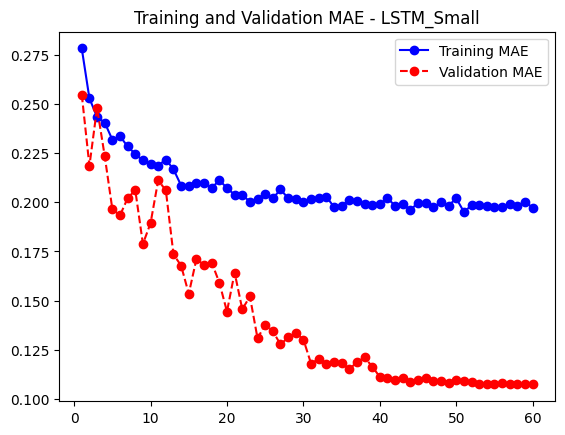

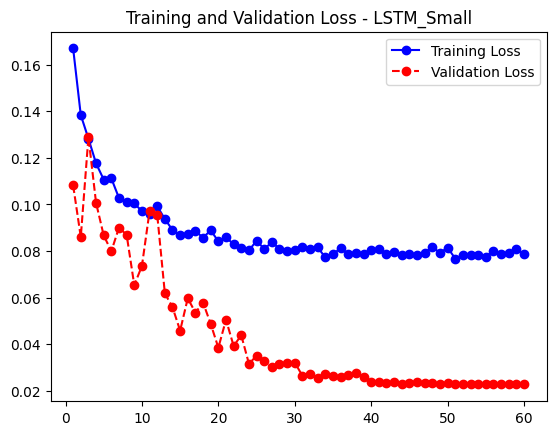

In [ ]:


# Define model configurations
def get_configurations():
    return {
        "LSTM_Small": {"Type": LSTM, "Depth": 2, "Units": 32, "DenseLayers": 1},

    }

# Function to build RNN models with Bidirectional layers based on configuration
def build_rnn(config):
    model = Sequential()

    for i in range(config["Depth"]):
        return_sequences = i < config["Depth"] - 1

        # Add Bidirectional wrapper around the RNN layer (LSTM)
        model.add(Bidirectional(config["Type"](config["Units"], return_sequences=return_sequences)))
        model.add(Dropout(0.5))  # Dropout for regularization


    for _ in range(config["DenseLayers"] - 1):
        model.add(Dense(64, activation='relu'))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train models with different configurations
configs = get_configurations()
results = {}

for name, config in configs.items():
    print(f"Training model: {name}")
    model = build_rnn(config)
    model.summary()

    # Define callbacks
    checkpoint = ModelCheckpoint(f"{name}.h5", save_best_only=True, monitor='val_loss', mode='min')
    lr_scheduler = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3, mode='min', min_lr=1e-07)

    history = model.fit(trainData, epochs=60, batch_size=128, validation_data=valData,
                        callbacks=[checkpoint, lr_scheduler])
    results[name] = model.evaluate(testData)
    plot_mae(history, name)


In [12]:
# Display results
for name, result in results.items():
    print(f"{name}: Loss (MSE) = {result[0]}, MAE = {result[1]}, MAE denormalized ={result[1]* stdSales}")

LSTM_Small: Loss (MSE) = 0.026686951518058777, MAE = 0.1156952828168869, MAE denormalized =66160.90050895792


### **Model Performance Comparison**  

The performance of **LSTM, Bidirectional LSTM** models:

- **LSTM Small** shows a better performance than **Bidirectional Small**, with a lower **MSE** and **MAE**, indicating a slight advantage in predictive accuracy for the standard LSTM model.  
- None of the models exhibit overfitting, as the training and evaluation errors remain consistent across different configurations.    

#### **Results Comparison**

1.   LSTM_Small BIDIRECTIONAL: Loss (MSE) = 0.026686951518058777, MAE = 0.1156952828168869, MAE denormalized =66160.90050895792




## Final comparison and visualization for different approaches

In [ ]:


# Simulation of results
results = {
    'Small SimpleRNN': [0.0414,  0.1329],  # [Loss (MSE), MAE]
    'Medium SimpleRNN': [0.1355,  0.3016],  
    'Small LSTM': [0.0310,  0.1139], 
    'Medium LSTM': [0.0422,  0.1511], 
    'Small GRU': [0.0355, 0.1268],  
    'Medium GRU': [0.0453, 0.1604],
    'Bidirectional LSTM small': [0.0266, 0.1156]
}


df_results = pd.DataFrame(
    [[name, result[0], result[1], result[1] * stdSales] for name, result in results.items()],
    columns=["Model", "Loss (MSE)", "MAE", "Denormalized MAE"]
)

df_results


,Model,Loss (MSE),MAE,Denormalized MAE
0,Small SimpleRNN,0.0414,0.1329,75999.500270
1,Medium SimpleRNN,0.1355,0.3016,172471.401665
2,Small LSTM,0.0310,0.1139,65134.259449
3,Medium LSTM,0.0422,0.1511,86407.257267
4,Small GRU,0.0355,0.1268,72511.186111
5,Medium GRU,0.0453,0.1604,91725.506721
6,Bidirectional LSTM small,0.0266,0.1156,66106.412575


**Analysis of Results**

* **Small LSTM**: It has the lowest Denormalized MAE of 65134, which means it makes predictions that are closest to the actual values when scaled back to the original range of the target variable.
I think that in the case of time series data, such as sales data, there are often patterns that depend on information from many time steps earlier. LSTMs use a cell state and gating mechanism to preserve and update information through time, which makes them more capable than simpler models like Simple RNNs.
The Small LSTM model performs well because it strikes a balance between complexity (2 layers) and the ability to capture long-term dependencies. The 2-layer configuration allows it to process sequences with reasonable depth without becoming too computationally expensive.

* **Bidirectional LSTM** also performs well with a Denormalized MAE of 66106, very close to the Small LSTM. The bidirectional approach processes the sequence both forwards and backwards, capturing context from both directions. This can be particularly beneficial when both past and future context are important for prediction. However, it doesn’t outperform because maybe 2 layers were not enough.


* **Simple RNN** struggles with long-term dependencies because it lacks the mechanisms to preserve past information over long sequences. This is evident from its higher denormalized MAE (759999 for small SimpleRNN). As the model depth increases (medium SimpleRNN), its performance worsens due to increased complexity and overfitting, leading to 172471 for denormalized MAE.

* **GRU**, while an improvement over Simple RNN in terms of computational efficiency and performance, still doesn't perform as well as LSTM. They are not as powerful as LSTMs in capturing long-term dependencies. This is reflected in their Denormalized MAE (72511 for small GRU and 91725 for medium GRU).


As the model complexity increases (from 2 layers to 4 layers), the performance worsens for all model types.




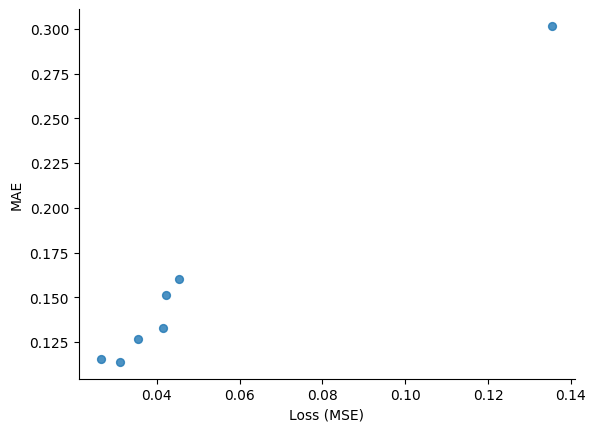

In [22]:
from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Loss (MSE)', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### To sum up, we created a graph representing each of the models performance in denormalized MAE where the red line represents the value we were encouraged to get (68000)

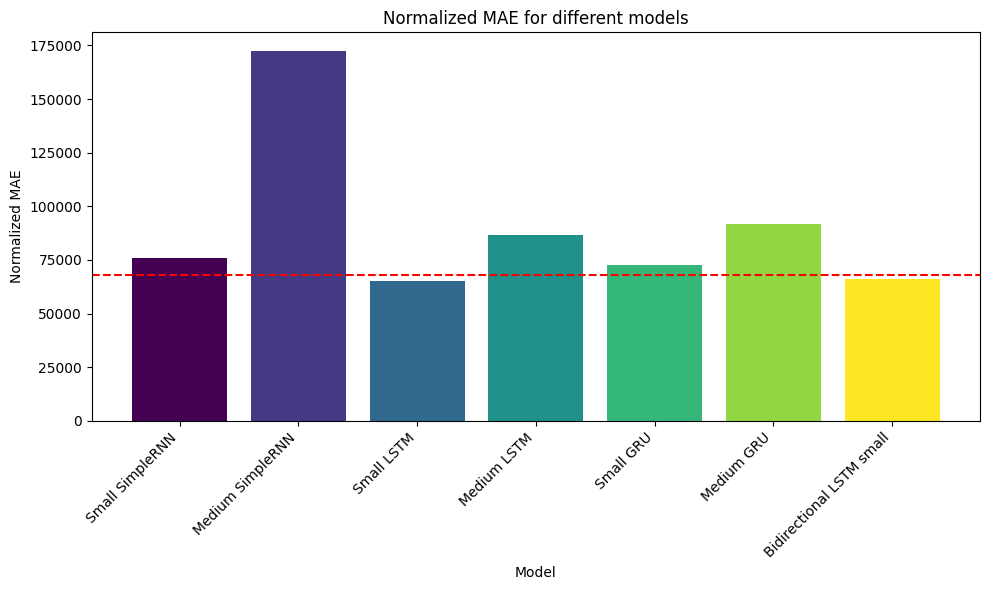

In [27]:

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(df_results)))

plt.bar(df_results['Model'], df_results['MAE']*stdSales, color=colors)
best_value = 68000
plt.axhline(y=best_value, color='r', linestyle='--', label=f"Best Value: {best_value}")
# Customize the plot
plt.xlabel('Model')
plt.ylabel('Normalized MAE')
plt.title('Normalized MAE for different models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

As we can see the best models that got to the asked performance were small LSTM and bidirectional LSTM small. Followed by small GRU and small SimpleRNN.